In [ ]:
# Code for the Book: International Stock Picking A.I. INVESTOR: A Guide to Build.
# Website: ai-investor.net
# Code needs am "All-In-One" subscription from the (presumably) nice people at https://eodhistoricaldata.com/. 
# Check the book text to see if they have changed their service since mid-2021.

# Damon Lee 2021

# Feel free to fork this code for others to see what can be done with it.

In [ ]:
myToken = 'ABC123.XXXXXX.84098767' # Own token from EODHistoricalData

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Set the plotting DPI settings to be a bit higher.
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

# Backtester

In [3]:
# Want this data to get stock and price information related
# to the predictions
stockData=pd.read_csv('stockData_2021.csv')
stockData['date']=pd.to_datetime(stockData['date'])
priceData = pd.read_csv('priceData_2021.csv', index_col=0)
priceData=priceData[~priceData.index.duplicated()]
print(priceData.shape)
print(stockData.shape)
print(priceData.index[-1])
print(stockData.index[-1])

C:\Users\G50\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (0,10,12,14,22,23,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(536960, 15)
(536960, 152)
536959
536959


In [4]:
X=pd.read_csv('filteredAnnualStockFeatures_2021.csv', index_col=0)
y=pd.read_csv('filteredAnnualStockPerformance_2021.csv', index_col=0)
print(X.shape)

(245705, 19)


In [5]:
'''X = X[['P/E', 'P/S', 'P/B', 'RoE', 'ROCE', 'grossProfitMargin',\
       'fixedAssetTurnover', 'workingAssetTurnover', 'workingCapitalRatio',\
       '(CA-CL)/TA', 'RE/TA', 'EBIT/TA', 'BookEquity/TL']]
       #'Debt/Equity', 'cashRatio', 'debtRatio', 'EV/EBIT', 'Op. In./(NWC+FA)']]'''

"X = X[['P/E', 'P/S', 'P/B', 'RoE', 'ROCE', 'grossProfitMargin',       'fixedAssetTurnover', 'workingAssetTurnover', 'workingCapitalRatio',       '(CA-CL)/TA', 'RE/TA', 'EBIT/TA', 'BookEquity/TL']]\n       #'Debt/Equity', 'cashRatio', 'debtRatio', 'EV/EBIT', 'Op. In./(NWC+FA)']]"

In [6]:
X.keys()

Index(['P/E', 'P/S', 'P/B', 'RoE', 'ROCE', 'grossProfitMargin',
       'fixedAssetTurnover', 'workingAssetTurnover', 'workingCapitalRatio',
       'BookEquity/TL', 'Debt/Equity', 'cashRatio', 'debtRatio', 'EV/EBIT',
       'Op. In./(NWC+FA)', 'Op. In./interestExpense', 'EBIT/TA', 'RE/TA',
       '(CA-CL)/TA'],
      dtype='object')

# Backtester - Fundamentals Stock Picker

In [7]:
def calcZScores(x):
    '''
    Calculate Altman Z'' scores 1995
    '''
    Z = pd.DataFrame(index=x.index)
    Z = 3.25 \
    + 6.51 * x['(CA-CL)/TA']\
    + 3.26 * x['RE/TA']\
    + 6.72 * x['EBIT/TA']\
    + 1.05 * x['BookEquity/TL']
    return Z

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

def newSKLearnRegressorModelAndPrediction(X_train, y_train, X_test, 
                                          randomState=42, 
                                          modelName='randomForest'):
    '''
    Contains all regression models for stock selection
    '''
    if modelName == 'randomForest':
        model = RandomForestRegressor(random_state=randomState, 
                                      n_estimators=100,
                                      max_depth=30).fit(X_train,
                                                        y_train.values.ravel())  
    elif modelName == 'KNN':
        model = Pipeline([('powerTransformer', PowerTransformer()),
                          ('knn', KNeighborsRegressor(n_neighbors=40))]).fit(X_train, 
                                                        y_train.values.ravel())  
        
    elif modelName == 'extraTrees':
        model = ExtraTreesRegressor(random_state=randomState, 
                                    n_estimators=100, 
                                    max_depth=200).fit(X_train, #maxdepth30
                                                        y_train.values.ravel())  
    
    elif modelName == 'gradBoost':
        model = GradientBoostingRegressor(random_state=randomState,
                                          learning_rate=0.1,
                                          n_estimators=300,
                                          subsample=1.0,
                                          max_features=None,
                                          max_depth=10).fit(X_train, 
                                                                 y_train.values.ravel()) 
    
    y_pred = model.predict(X_test)
    return y_pred

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'# For CPU Only
import tensorflow as tf
from tensorflow import keras
import logging
logging.getLogger('tensorflow').disabled=True
#from tensorflow.python.client import device_lib
#print(tf.__version__,'\n',keras.__version__)
#print(device_lib.list_local_devices())
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import MinMaxScaler

def newNNRegressorModelAndPrediction(X_fundamentalData, y_performanceData, 
                                     X_train, y_train, X_test):
    '''
    Train new neural net for stock selection
    '''
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(18, activation = 'relu', \
                                 input_shape = (X_train.shape[1],)))
    model.add(keras.layers.Dense(18, activation='relu'))
    model.add(keras.layers.Dense(18, activation='relu'))
    model.add(keras.layers.Dense(10, activation='relu'))
    model.add(keras.layers.Dense(10, activation='relu'))
    model.add(keras.layers.Dense(1, activation='relu'))
    
    
    optimizer = keras.optimizers.Adam(learning_rate = 0.1,
                                      amsgrad = False)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    #scaling for NN
    min_max_scaler = MinMaxScaler()
    X_fundamentalData_t = \
    pd.DataFrame(min_max_scaler.fit_transform(power_transform(X_fundamentalData)), 
                 index=X_fundamentalData.index)
    
    y_performanceData_t = \
    pd.DataFrame((y_performanceData+1).values.reshape(-1,1)/11, 
                 index=y_performanceData.index)
    
    X_test_t = \
    X_fundamentalData_t[X_fundamentalData_t.index.isin(X_test.index)].values
    X_train_t = \
    X_fundamentalData_t[X_fundamentalData_t.index.isin(X_train.index)].values
    y_train_t = \
    y_performanceData_t[y_performanceData_t.index.isin(y_train.index)].values
    
    
    #model.fit(X_train_t, y_train_t, epochs=40, batch_size=512, verbose=0)
    model.fit(X_train_t, y_train_t, epochs=200, batch_size=512, verbose=0)
    y_pred = model.predict(X_test_t)
    y_pred = (y_pred * 11) - 1
    
    return y_pred.ravel()

In [13]:
def fundamentalStockPicker(windowDateFrom, windowDateTo, 
                           X_fundamentalData, y_performanceData, 
                           stockData, priceData,
                           country=None, zScore=None, randomState=42, 
                           modelName='randomForest',
                           numberOfStocks=10,
                           verbose=False):
    '''
    Select stocks in the given date window, using information from X and y before 
    the investment window start date to train the model.
    The investment window is a few months backwards as this is when the actual 
    data would be available for us (publish date).
    
    Stock selection done with random forest by default.
    
    Returns DataFrame of prediction, target, stock ticker, exchange, 
    dates and prices bought/sold of best predicted returns
    '''
    # Boolean mask of stocks before the investment window, that
    # can be used as training data
    beforeWindow = stockData['date']<\
                    pd.to_datetime(windowDateFrom)-pd.Timedelta(days=120) 
    
    # Boolean mask of stocks within the investment window, that
    # we can select stocks from for investment
    inWindow = stockData['date'].between(\
                     pd.to_datetime(windowDateFrom)-pd.Timedelta(days=120),\
                     pd.to_datetime(windowDateTo)-pd.Timedelta(days=120))
    
    X_train = X_fundamentalData.loc[beforeWindow]
    y_train = y_performanceData.loc[beforeWindow]

    X_test = X_fundamentalData.loc[inWindow]
    y_test = y_performanceData.loc[inWindow]
    
    # Filter by country if desired
    if country:
        X_test = X_test.loc[stockData['CountryName']==country]
        y_test = y_test.loc[stockData['CountryName']==country]
        
    # Filter stock selection by Z-Score if desired
    if zScore:
        X_test=X_test.loc[calcZScores(X_test) > zScore]
        #y_test=y_test.loc[X_test.index]
        y_test=y_test.reindex(X_test.index)
        
    if verbose:
        print('Selecting From: ', y_test.shape[0], 'Stocks')
    
    # Now select which regression model to use
    if modelName == 'neuralNet':
        y_pred = newNNRegressorModelAndPrediction(X_fundamentalData, 
                                                  y_performanceData, 
                                                  X_train, y_train, X_test)
    elif modelName in ['randomForest', 'extraTrees', 'KNN', 'gradBoost']:
        y_pred = newSKLearnRegressorModelAndPrediction(X_train, y_train, X_test, 
                                                       randomState=randomState,
                                                       modelName=modelName)
    else:
        y_pred = np.random.rand(X_test.shape[0]) # Random seleciton for testing
    
    # Create the output DataFrame containing ancillary data and the 
    # predicted stock performance. We select the best stocks from here.
    listOfPickedStocks = pd.DataFrame()
    listOfPickedStocks['Prediction'] = y_pred
    listOfPickedStocks.index = X_test.index
    listOfPickedStocks['Target'] = y_test
    listOfPickedStocks['Code'] = stockData['Code'].loc[X_test.index]
    listOfPickedStocks['Exchange'] = stockData['Exchange'].loc[X_test.index]
    
    listOfPickedStocks['buyDate'] = \
    pd.to_datetime(priceData.loc[X_test.index]['startDate'])
    listOfPickedStocks['sellDate'] = \
    pd.to_datetime(priceData.loc[X_test.index]['endDate'])
    
    listOfPickedStocks['buyPrice'] = priceData.loc[X_test.index]['startClose']
    listOfPickedStocks['sellPrice'] = priceData.loc[X_test.index]['endClose']
    
    listOfPickedStocks['startAdjusted'] = \
    priceData.loc[X_test.index]['startAdjusted_close']
    listOfPickedStocks['endAdjusted'] = \
    priceData.loc[X_test.index]['endAdjusted_close']
    
    listOfPickedStocks['zScore'] = calcZScores(X_test)
    
    #print('Train size=', y_train.shape[0])
    #print('Test size=', y_test.shape[0])
    return listOfPickedStocks.sort_values(by=['Prediction'], ascending=False).head(numberOfStocks) # must be ascending = False.

In [15]:
fundamentalStockPicker('2016-06-01', '2017-01-01', X, y, 
                       stockData, priceData, 'UK', modelName='random', 
                       verbose=True)

Selecting From:  445 Stocks


,Prediction,Target,Code,Exchange,buyDate,sellDate,buyPrice,sellPrice,startAdjusted,endAdjusted,zScore
435854,0.999846,-0.557969,RCN,LSE,2016-07-29,2017-07-31,178.750,79.0000,176.4082,77.9779,4.809943
335585,0.999653,0.422539,JZCP,LSE,2016-06-28,2017-06-28,402.500,558.1000,392.3266,558.1000,14.311783
267676,0.999064,0.618519,EYE,LSE,2016-10-28,2017-10-30,135.000,218.5000,135.0000,218.5000,0.044928
292694,0.998929,0.282473,GNS,LSE,2016-10-28,2017-10-30,1895.000,2430.0000,1894.0494,2429.0671,6.794424
203903,0.998078,0.242187,BXP,LSE,2016-10-28,2017-10-30,48.000,59.6250,43.5989,54.1580,8.703202
153676,0.996008,0.489011,AGY,LSE,2016-10-28,2017-10-30,22.750,33.8750,22.7500,33.8750,-0.915489
421044,0.994529,0.031336,PNL,LSE,2016-08-30,2017-08-29,39890.000,41140.0000,39890.0000,41140.0000,109.379023
431121,0.993417,-0.623918,QFI,LSE,2016-10-28,2017-10-30,11.500,4.3249,11.1324,4.1867,-9.962200
254024,0.989312,0.029850,EDIN,LSE,2016-07-29,2017-07-31,712.000,733.0000,710.5364,731.7458,12.262577
496351,0.986757,0.032864,TRAF,LSE,2016-07-29,2017-07-31,1.065,1.1000,10.6500,11.0000,5.923706


In [54]:
fundamentalStockPicker('2016-06-01', '2017-01-01', X, y, 
                       stockData, priceData, 'UK', modelName='KNN')

,Prediction,Target,Code,Exchange,buyDate,sellDate,buyPrice,sellPrice,startAdjusted,endAdjusted,zScore
535255,0.451485,0.125000,ZIN,LSE,2016-10-28,2017-10-30,0.800,0.900,400.0000,450.0000,-6.927271
324191,0.360790,-0.000699,INV,LSE,2016-10-28,2017-10-30,360.000,338.000,294.4511,294.2453,39.405935
416014,0.347192,0.049567,PGOO,LSE,2016-06-28,2017-06-28,71.500,75.000,71.2207,74.7509,109.300359
428181,0.346408,0.000000,PU11,LSE,2016-06-28,2017-06-28,95.000,95.000,88.5339,88.5339,28.482433
272363,0.336835,-0.102823,FFWD,LSE,2016-07-29,2017-07-31,12.400,11.125,12.4000,11.1250,112.705570
243295,0.333010,2.209302,DIS,LSE,2016-07-29,2017-07-31,1.075,3.450,1.0750,3.4500,17.047591
309193,0.331172,0.062500,HPAC,LSE,2016-07-29,2017-07-31,80.000,85.000,80.0000,85.0000,109.970766
332134,0.330164,0.330503,JETG,LSE,2016-07-29,2017-07-31,235.000,304.250,206.9576,275.3577,9.318152
480296,0.327589,0.333510,SYNC,LSE,2016-07-29,2017-07-31,129.000,172.000,128.9566,171.9649,105.192536
155675,0.322235,0.282794,AJG,LSE,2016-08-30,2017-08-29,146.750,188.250,146.6620,188.1372,25.391923


In [56]:
fundamentalStockPicker('2016-06-01','2017-01-01', X, y, stockData, priceData, 'Italy')

,Prediction,Target,Code,Exchange,buyDate,sellDate,buyPrice,sellPrice,startAdjusted,endAdjusted,zScore
473600,0.470036,1.496094,SSL,MI,2016-10-28,2017-10-30,0.5120,1.2780,0.5120,1.2780,0.632846
172497,0.368268,0.013304,ASR,MI,2016-10-28,2017-10-30,0.4510,0.4570,0.4510,0.4570,-1.699499
335193,0.280972,1.521309,JUVE,MI,2016-10-28,2017-10-30,0.2933,0.7395,0.2933,0.7395,1.716119
238194,0.227656,0.190030,DAN,MI,2016-10-28,2017-10-30,17.1200,20.2500,16.5058,19.6424,5.885747
456664,0.150488,0.639790,SES,MI,2016-08-29,2017-08-28,15.0800,23.9500,13.7553,22.5558,6.223290
423587,0.119947,0.624186,PQ,MI,2016-07-29,2017-07-31,1.1650,1.7850,1.0295,1.6721,8.653069
172682,0.107254,0.993271,ASSI,MI,2016-10-28,2017-10-30,1.4750,2.9400,1.3226,2.6363,3.350914
242655,0.106852,0.083811,DIB,MI,2016-10-28,2017-10-30,11.6900,12.5600,11.3327,12.2825,6.916259


In [57]:
fundamentalStockPicker('2010-06-01','2011-01-01', X, y, stockData, priceData, 'Indonesia')

,Prediction,Target,Code,Exchange,buyDate,sellDate,buyPrice,sellPrice,startAdjusted,endAdjusted,zScore
471610,0.184392,2.002690,SQMI,JK,2010-07-29,2011-07-29,63.2766,190.0,63.2766,190.0000,4.313108
304093,0.141516,0.387564,HEXA,JK,2010-07-29,2011-07-29,5950.0000,8050.0,1976.4978,2742.5178,2.388851
440294,0.109500,-0.102941,RIGS,JK,2010-07-29,2011-07-29,680.0000,610.0,680.0000,610.0000,5.087025


# Backtester - Price Timeseries Functions

In [11]:
import requests
from io import StringIO # read string as file for pandas

def get_eod_data(startDate, endDate, symbol='MCD.US', 
                 api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX', session=None):
    '''
    Make API call to EODHistoricalData to get financial price series for a ticker.
    Returns a DataFrame.
    
    If an error is present, the StockWithIssues.txt will have an entry, and the
    returned price series will just be 1's as if uninvested.
    '''
    if session is None:
        session = requests.Session()
    url = 'https://eodhistoricaldata.com/api/eod/%s' % symbol
    params = {'api_token': api_token, 'from':startDate, 'to':endDate}
    r = session.get(url, params=params)
    
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), 
                         skipfooter=1, parse_dates=[0], 
                         engine='python', index_col=0)
        
        if df.shape[0] == 0: # in case of error return constant price.
            df=pd.DataFrame(index=pd.date_range(start=startDate, end=endDate), 
                            columns=['Adjusted_close'])
            df['Adjusted_close']=1
        return df
    else:
        # We don't want the backtest to stop if we reach an error
        # We will force the ticker to be equivalent to being uninvested
        with open("StockWithIssues.txt", "a") as myfile:
            myfile.write(symbol+'\n')
            myfile.close()
        tempDf=pd.DataFrame(index=pd.date_range(start=startDate, end=endDate), columns=['Adjusted_close'])
        tempDf['Adjusted_close']=1
        return tempDf
        
#test = get_eod_data('2016-01-01','2016-05-30', symbol='MCD.US', api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX')
#test = get_eod_data('2016-01-01','2016-05-30', symbol='LPPF.JK', api_token=myToken)
#test

In [12]:
get_eod_data('2016-01-01','2016-05-30', symbol='MCD.US', 
             api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX')

,Open,High,Low,Close,Adjusted_close,Volume
Date,,,,,,
2016-01-04,117.25,117.73,115.8700,117.58,102.1229,9995004
2016-01-05,117.41,119.23,117.2900,119.20,103.5299,6314015
2016-01-06,118.00,119.27,117.8100,118.40,102.8351,6543760
2016-01-07,117.44,117.97,115.5900,115.66,100.4553,7477876
2016-01-08,115.75,117.47,115.2600,115.48,100.2989,6103431
...,...,...,...,...,...,...
2016-05-23,122.76,123.73,122.4700,122.81,107.4734,7081628
2016-05-24,123.39,124.77,123.0100,123.95,108.4710,4494691
2016-05-25,123.75,123.99,123.0315,123.26,107.8672,5307678


In [60]:
get_eod_data('2016-01-01','2016-05-30', symbol='ETM.US', 
             api_token='OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX')

,Adjusted_close
2016-01-01,1
2016-01-02,1
2016-01-03,1
2016-01-04,1
2016-01-05,1
...,...
2016-05-26,1
2016-05-27,1
2016-05-28,1
2016-05-29,1


In [12]:
def getPortfolioRelativeTimeSeries(stockRet):
    '''
    Normalise a dataframe of stock prices of a portfolio over time.
    As a column for the overall portfolio value change.
    '''
    stockRetRel = stockRet.copy()
    
    # Make the price data relative
    for key in stockRetRel.keys():
        stockRetRel[key]=stockRetRel[key]/stockRetRel[key][0]
        
    #stockRetRel["Portfolio"] = \
    #stockRetRel.sum(axis=1)/(stockRetRel.keys().shape[0])
    
    # Averaged out, it becomes the portfolio performance
    stockRetRel["Portfolio"] = \
    stockRetRel.sum(axis=1)/stockRetRel.iloc[0].sum()
    
    return stockRetRel

def calcPortBacktestTimeSeries(dateStart, dateEnd, listOfTickersToAdd, 
                               portValOverTime=pd.DataFrame()):
    '''
    Calculate the time series of the backtest portfolio.
    Makes API calls to get price series for component stocks 
    (and normalises them all to start at 1).
    Does an average to find portfolio value over time.
    '''
    # Create an empty DataFrame with the dates
    currentWindowStockValues = pd.DataFrame(index=pd.date_range(dateStart, 
                                                                dateEnd))
    # Loop over the stock tickers we want to add
    for ticker in listOfTickersToAdd:
        # Record the price series data for that stock ticker
        currentWindowStockValues[ticker] = \
        get_eod_data(dateStart, dateEnd, 
                     symbol=ticker, 
                     api_token=myToken)['Adjusted_close']
        
        currentWindowStockValues[ticker].ffill(inplace=True)
    
    # Propagate last applicable value forward
    # Any remaining spaces propagate closest applicable valie backward
    currentWindowStockValues.ffill(inplace=True)
    currentWindowStockValues.bfill(inplace=True)
    
    currentWindowStockValuesRelative = \
    getPortfolioRelativeTimeSeries(currentWindowStockValues)
    
    # View the stock portfolio, for debugging
    #currentWindowStockValuesRelative.to_csv(\
    #str(dateStart.strftime('%Y-%m-%d'))+'.csv')
    
    #append rows to portValOverTime
    if portValOverTime.empty:
        portValOverTime = currentWindowStockValuesRelative['Portfolio']
    else:
        portValOverTime = portValOverTime.append(\
                          currentWindowStockValuesRelative['Portfolio']*\
                                                 portValOverTime.iloc[-1])
        
    return portValOverTime

2017-01-01    1.000000
2017-01-02    1.000000
2017-01-03    1.000000
2017-01-04    1.013241
2017-01-05    1.012940
Freq: D, Name: Portfolio, dtype: float64

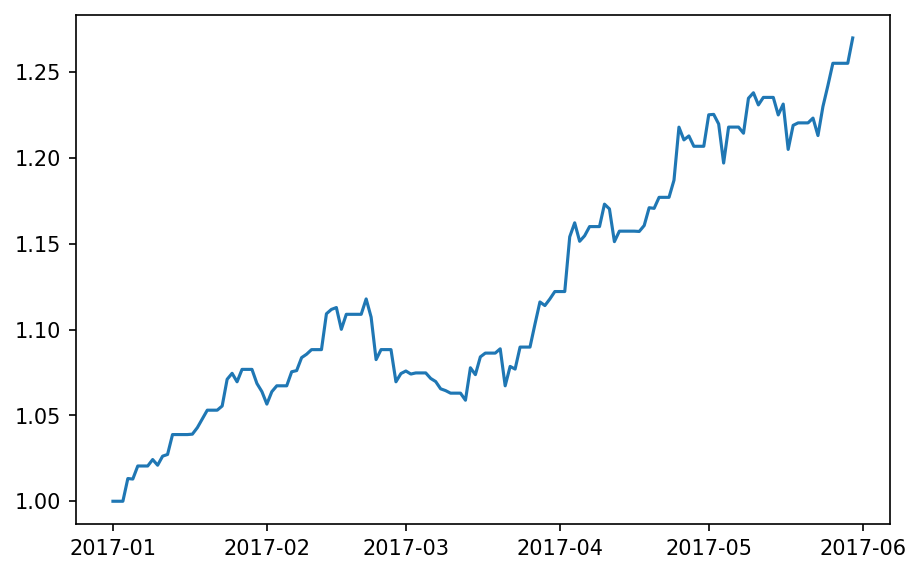

In [14]:
a=calcPortBacktestTimeSeries(pd.to_datetime('2017-01-01'),
                             pd.to_datetime('2017-05-30'), 
                             ['MCD.US', 'INTC.US','TSLA.US'])
plt.plot(a)
a.head()

# Backtester - Investment Schedule Loop

### Underlying Basic Loop for Stock Selection

In [67]:
# Pick stocks every 6 months
investmentSchedule = pd.date_range(start='2009-01-01', periods=4, freq='6MS')

for i in range(len(investmentSchedule)-1):
    
    # Get the stock picks for that timeframe
    pickedStocks = \
    fundamentalStockPicker(investmentSchedule[i]-pd.Timedelta(days=30*6),
                           investmentSchedule[i],
                           X, y, stockData, priceData,
                           country='USA', zScore=2.6, randomState=42,
                           modelName='neuralNet')
    
    #Let's see what stocks the AI Investor picked.
    print(pickedStocks[['Prediction','Target','Code','Exchange',\
                        'buyDate','sellDate','zScore']],
          '\n-------------------------------------') # display the DataFrame

        Prediction    Target   Code Exchange    buyDate   sellDate      zScore
360905    0.432497 -0.243009  MARPS   NASDAQ 2008-10-28 2009-10-28  128.122500
179828    0.401983  0.201824    AZO     NYSE 2008-12-29 2009-12-29    3.712318
515141    0.369342  0.290840  VLGEA   NASDAQ 2008-11-28 2009-11-30    6.475016
337066    0.323009  0.269264   KBAL   NASDAQ 2008-10-28 2009-10-28    8.025669
397698    0.291321  0.002118    NXQ     NYSE 2008-07-29 2009-07-29   70.835065
208275    0.273081 -0.031875   CASY   NASDAQ 2008-08-28 2009-08-28    6.420857
280214    0.264365  0.813124     FT     NYSE 2008-12-29 2009-12-29    7.099091
231929    0.263602  0.838710   CTHR   NASDAQ 2008-10-28 2009-10-28   17.859438
482341    0.244991 -0.200404    TAK     NYSE 2008-07-29 2009-07-29   15.235759
167646    0.242167 -0.796000   APPS   NASDAQ 2008-07-29 2009-07-30   21.957808 
-------------------------------------
        Prediction    Target  Code  Exchange    buyDate   sellDate     zScore
217977    0.58

### Backtester, Can be Annual or Bi-Annual

In [18]:
def backTest(randomState=42, zScore=2.6, numStocksInPortfolio=10,
             modelName='randomForest', country='USA', 
             verbose=True, biAnnual=False):
    '''
    Run an AI Investor a backtest, 
    return the DataFrame with relative portfolio value over time.
    
    Stocks held for 1 year. Stock selection can be every 6 months,
    or yearly.
    '''
    
    # Set up the investment schedule
    if biAnnual:
        investmentSchedule = \
        pd.date_range(start='2009-01-01', periods=23, freq='6MS')
        
    else:
        investmentSchedule = \
        pd.date_range(start='2009-01-01', 
                      periods=11, 
                      freq='Y') + pd.to_timedelta('26w') # start every End April
    
    # Store the invested stock tickers in lists
    pickedStockTickers, currPortfolioStockTickers = [], []
    
    # Store the portfolio value over time
    portValOverTime = pd.DataFrame()

    for i in range(len(investmentSchedule)-1):
        
        # Get the regressor to pick stocks for the period
        pickedStocks = \
        fundamentalStockPicker(investmentSchedule[i]-pd.Timedelta(days=30*6),
                               investmentSchedule[i],
                               X, y, stockData, priceData,
                               country=country, zScore=zScore, 
                               randomState=randomState, modelName=modelName,
                               verbose=verbose)
            
        pickedStocks['Exchange'][pickedStocks['Exchange'].isin(['NYSE MKT', 
                                                                'NASDAQ', 
                                                                'PINK', 
                                                                'NYSE ARCA', 
                                                                'NYSE'])]='US'
        
        # Text output
        if verbose:
            print('Picked stocks from last 6M data for investment starting:',\
                  investmentSchedule[i].strftime('%Y-%m-%d'),\
                  ', Ending:',\
                  investmentSchedule[i+1].strftime('%Y-%m-%d'))
            print('Using model: ', modelName)
            print(pickedStocks[['Prediction','Target','Code','Exchange',\
                                'buyDate','sellDate','zScore']])  
            print('--------------------------------------------')

        pickedStocks['ticker'] = \
        pickedStocks['Code'].astype(str)+'.'+pickedStocks['Exchange']

        if biAnnual:
            numberStocksToAddToPortfolio = numStocksInPortfolio // 2
        else:
            numberStocksToAddToPortfolio = numStocksInPortfolio
        
        # Just use a list to manage stocks held.
        for stock in pickedStocks['ticker'].head(numberStocksToAddToPortfolio):
            currPortfolioStockTickers.append(stock)
        while len(currPortfolioStockTickers) > numStocksInPortfolio:
            currPortfolioStockTickers.pop(0)
            
        # Record the portfolio value over time.
        portValOverTime = calcPortBacktestTimeSeries(investmentSchedule[i],
                                                     investmentSchedule[i+1] - pd.Timedelta(1, unit="d"), 
                                                     currPortfolioStockTickers, 
                                                     portValOverTime)

    return portValOverTime

# Example Annual Backtest with Random Forest

In [19]:
portValOverTime=backTest()

Selecting From:  1490 Stocks
Picked stocks from last 6M data for investment starting: 2010-07-01 , Ending: 2011-07-01
Using model:  randomForest
        Prediction    Target  Code Exchange    buyDate   sellDate     zScore
204659    3.842287  0.319307   BZH       US 2010-01-28 2011-01-28   7.933476
203801    2.372772 -0.275449   BXC       US 2010-04-30 2011-05-02   4.583055
479159    2.342198 -0.063830  SWKH       US 2010-04-30 2011-05-02  47.753900
236993    2.314568  0.330049   CZR       US 2010-04-30 2011-05-02   2.970518
309034    2.208339  0.030303   HOV       US 2010-03-01 2011-02-28   2.636779
323666    2.193896 -0.174766  INSM       US 2010-04-30 2011-05-02  56.637094
330582    1.854984  0.328974  JAKK       US 2010-04-30 2011-05-02   5.523007
361909    1.545672  0.040710   MBI       US 2010-04-30 2011-05-02  29.601495
317050    1.529742 -0.066152  IDXG       US 2010-04-30 2011-05-02   4.122707
484994    1.405047  0.059603   TCX       US 2010-04-30 2011-05-02   5.070678
--------

Selecting From:  2222 Stocks
Picked stocks from last 6M data for investment starting: 2018-07-01 , Ending: 2019-07-01
Using model:  randomForest
        Prediction    Target   Code Exchange    buyDate   sellDate     zScore
454552    3.708088 -0.205640    SCU       US 2018-04-30 2019-04-30  15.435746
182873    2.288770  0.290851  BATRA       US 2018-04-30 2019-04-30  14.387278
309047    1.945195 -0.689404    HOV       US 2018-02-28 2019-02-28   3.262650
356262    1.820395  0.329053  LTRPB       US 2018-05-07 2019-05-14   4.016910
207522    1.697481 -0.122581    CAP       US 2018-04-30 2019-04-30  14.946252
220421    1.539900 -0.102230   CLNC       US 2018-04-30 2019-04-30  40.126092
163671    1.180174 -0.158327    AMR       US 2018-04-30 2019-04-30   7.003684
488606    1.162482  0.048632     TH       US 2018-04-30 2019-04-30  15.806690
466249    1.092986 -0.728304  SMRTQ       US 2018-05-31 2019-05-31   4.365312
277319    1.076362 -0.125753   FOSL       US 2018-04-30 2019-04-30   5.4906

In [20]:
import pandas_datareader.data as pdr
def dataForTicker(ticker, start, end):
    tickerData = pdr.DataReader(ticker, "yahoo", start, end);
    return tickerData

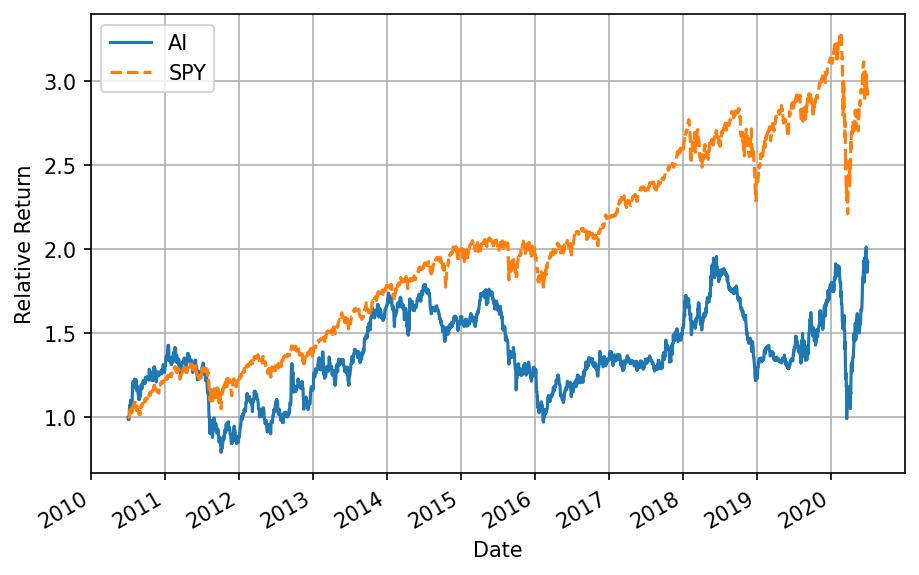

In [85]:
# Get the S&P500 index to compare backtest to
spy = dataForTicker('spy', portValOverTime.index[0], portValOverTime.index[-1]) # ISF.MI for FTSE 100
spy = getPortfolioRelativeTimeSeries(spy)

# Compare the backtest
#plt.figure(figsize=(20,10))
portValOverTime.plot()
spy['Open'].plot(ls='dashed')
plt.legend(['AI','SPY'])
plt.ylabel('Relative Return')
plt.grid()

# Example Bi-Annual Backtest

In [86]:
portValOverTime=backTest(biAnnual=True, modelName='KNN')

--------------------------------------------
Picked stocks from last 6M data for investment starting: 2009-01-01 , Ending: 2009-07-01
Using model:  neuralNet
        Prediction    Target   Code Exchange    buyDate   sellDate      zScore
360905    0.347240 -0.243009  MARPS       US 2008-10-28 2009-10-28  128.122500
370722    0.311568 -0.246121   MLHR       US 2008-09-29 2009-09-28    5.594691
337066    0.299076  0.269264   KBAL       US 2008-10-28 2009-10-28    8.025669
179828    0.253024  0.201824    AZO       US 2008-12-29 2009-12-29    3.712318
476443    0.247522  1.237483    STX       US 2008-10-28 2009-10-28    3.333716
312687    0.243306  0.336929   HWKN       US 2008-07-29 2009-07-29   24.353961
394214    0.241511 -0.262427   NTCT       US 2008-07-29 2009-07-29    4.685870
274134    0.236078  1.631579   FKWL       US 2008-10-28 2009-10-28    9.634826
499242    0.233665 -0.073981   TSRI       US 2008-09-29 2009-09-28   15.665227
167646    0.233459 -0.796000   APPS       US 2008-07

--------------------------------------------
Picked stocks from last 6M data for investment starting: 2013-07-01 , Ending: 2014-01-01
Using model:  neuralNet
        Prediction    Target  Code Exchange    buyDate   sellDate     zScore
162787    0.598675  0.357570  AMED       US 2013-04-30 2014-04-30   4.383825
471248    0.591643  0.307313  SPTN       US 2013-04-30 2014-04-30   4.960192
409916    0.549145  0.509315   PAG       US 2013-04-30 2014-04-30   4.063670
530343    0.526456  0.183034   XOM       US 2013-04-30 2014-04-30   8.211753
307848    0.525130  0.050440   HNI       US 2013-04-30 2014-04-30   5.097282
467073    0.523915  0.016769  SNEX       US 2013-01-28 2014-01-28   4.433494
184012    0.521048  1.397285   BBQ       US 2013-04-30 2014-04-30   5.718133
450198    0.517675  0.509164  SAIA       US 2013-04-30 2014-04-30   4.672299
185966    0.495831  0.941366   BDL       US 2013-01-28 2014-01-28  19.094757
477114    0.495298  0.428333   SUN       US 2013-04-30 2014-04-30   4.01

--------------------------------------------
Picked stocks from last 6M data for investment starting: 2018-01-01 , Ending: 2018-07-01
Using model:  neuralNet
        Prediction    Target   Code Exchange    buyDate   sellDate     zScore
145593        -1.0  1.406780   ABMD       US 2017-07-31 2018-07-30  10.999647
408179        -1.0  0.089159  OXLCM       US 2017-07-31 2018-07-30   5.906467
407273        -1.0 -0.048185   OTEX       US 2017-10-30 2018-10-29   6.421132
406673        -1.0 -0.226107   OSIS       US 2017-10-30 2018-10-29   6.779893
405230        -1.0  0.089530   ORCL       US 2017-09-28 2018-09-28   7.315996
403922        -1.0 -0.500000   ONVO       US 2017-07-31 2018-07-30   5.284266
401868        -1.0  0.025362    OIA       US 2017-09-28 2018-09-28   9.076352
401490        -1.0  0.102661    OGI       US 2017-12-29 2018-12-31  13.331980
400416        -1.0 -0.327393    ODC       US 2017-11-28 2018-11-28   9.308581
397736        -1.0  0.015175    NXR       US 2017-07-31 2018-0

Text(0.5, 1.0, 'Neural Net, Bi-Annual Stock Selection Backtest')

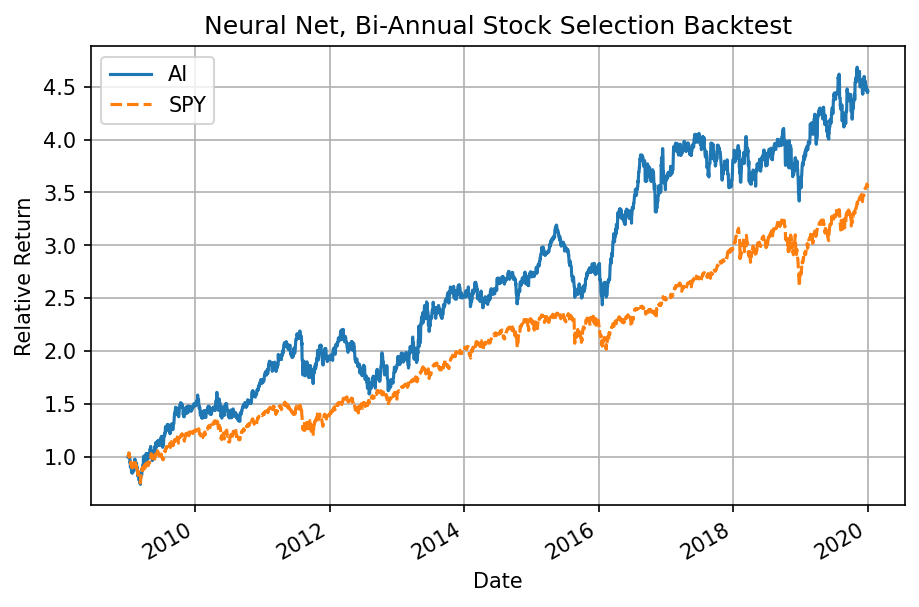

In [90]:
spy = dataForTicker('spy', portValOverTime.index[0], portValOverTime.index[-1]) # ISF.MI for FTSE 100
spy = getPortfolioRelativeTimeSeries(spy)
#plt.figure(figsize=(20,10))
portValOverTime.plot()
spy['Open'].plot(ls='dashed')
plt.legend(['AI','SPY'])
plt.ylabel('Relative Return')
plt.grid()
plt.title('Neural Net, Bi-Annual Stock Selection Backtest')

# Example Annual Backtest China

In [16]:
portValOverTime=backTest(country='China',
                         zScore=2.6,
                         biAnnual=False,
                         modelName='gradBoost')

--------------------------------------------
Picked stocks from last 6M data for investment starting: 2010-07-01 , Ending: 2011-07-01
Using model:  gradBoost
        Prediction    Target    Code Exchange    buyDate   sellDate     zScore
67073     1.748959  0.259663  300032      SHE 2010-04-30 2011-05-03  12.607047
140083    0.916060  0.280992  900957      SHG 2010-04-30 2011-05-03   3.668109
110983    0.853137 -0.177179  600340      SHG 2010-04-30 2011-05-03   9.919685
116590    0.681736 -0.073550  600739      SHG 2010-04-30 2011-05-03  10.062460
67148     0.586328 -0.076593  300037      SHE 2010-04-30 2011-05-03  15.874373
106741    0.533130  0.018024  600099      SHG 2010-04-30 2011-05-03  17.320124
119411    0.512062 -0.072946  600900      SHG 2010-04-30 2011-05-03   3.111232
139898    0.502813 -0.060332  900929      SHG 2010-04-30 2011-05-03   4.898606
139853    0.467593  0.317852  900926      SHG 2010-04-30 2011-05-03   2.823231
54239     0.464457 -0.101902  200725      SHE 2010-0

--------------------------------------------
Picked stocks from last 6M data for investment starting: 2018-07-01 , Ending: 2019-07-01
Using model:  gradBoost
        Prediction    Target    Code Exchange    buyDate   sellDate     zScore
53990     1.349630 -0.295455  200505      SHE 2018-05-02 2019-04-30   4.517171
126297    1.180775 -0.411457  603937      SHG 2018-05-02 2019-04-30  14.699058
73020     1.148019 -0.103695  300527      SHE 2018-05-02 2019-04-30   8.976952
72144     0.777097 -0.354155  300432      SHE 2018-05-02 2019-04-30   8.444525
115970    0.750958 -0.340347  600707      SHG 2018-05-02 2019-04-30   4.590406
118472    0.749614  0.106529  600847      SHG 2018-05-02 2019-04-30   7.956630
114544    0.654370 -0.005866  600618      SHG 2018-05-02 2019-04-30   6.385813
111579    0.625202  0.256828  600378      SHG 2018-05-02 2019-04-30  22.254690
115438    0.578774  0.040482  600674      SHG 2018-05-02 2019-04-30   8.964446
107126    0.572237 -0.427778  600119      SHG 2018-0

<AxesSubplot:>

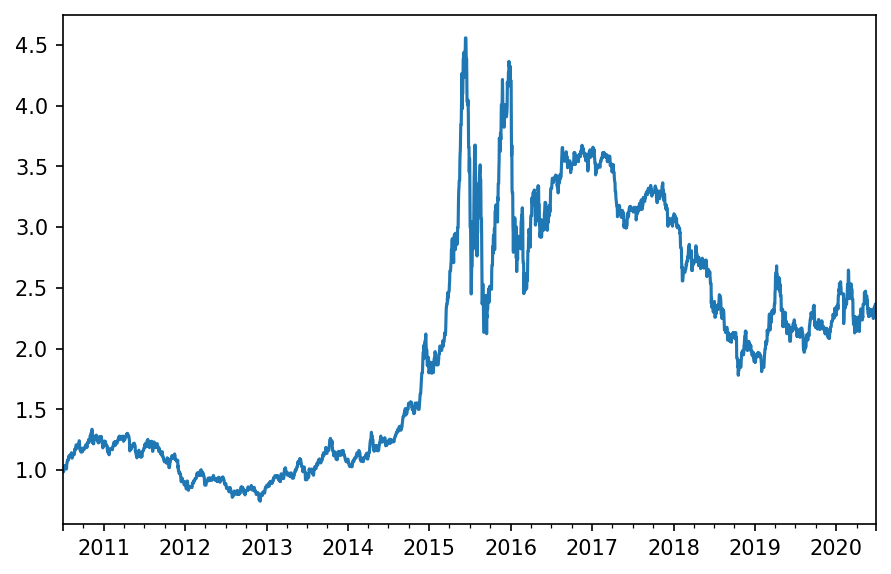

In [17]:
portValOverTime.plot()

# Backtest Benchmarking Stock Prediction Regressors (Single Core)

In [ ]:
# Random Selection Benchmark
backtestBenchmarkRuns_Random_Annual = pd.DataFrame()

for i in range(100):
    backtestBenchmarkRuns_Random_Annual[i] = \
    backTest(randomState=i, 
             modelName='random', # 'neural net etc.'
             biAnnual=False,
             verbose=False)
    
    print('Running backtest No. ', i,
          'Return: ', backtestBenchmarkRuns_Random_Annual[i].iloc[-1])
    
    backtestBenchmarkRuns_Random_Annual.to_csv(\
                        'backtestBenchmarkRuns_Random_Annual.csv')

# Backtest Benchmarking Stock Prediction Regressors (Parallel)
Parallel code with threading (https://docs.python.org/3/library/threading.html).
Not bothering with killing threads elegantly.

In [49]:
# Parallel
import os
import threading
import numpy as np
#https://docs.python.org/3/library/threading.html

def addBacktestResults(backtestResult, backtestResultsFileName, multithreadingLock):
    """https://docs.python.org/3/library/threading.html"""
    
    multithreadingLock.acquire() # can use "with" too.
    if not os.path.exists(backtestResultsFileName):
        backtestResult.to_csv(backtestResultsFileName)
        print('Writing backtest number: 0')
    else:
        currentBacktests = pd.read_csv(backtestResultsFileName, 
                                       index_col=0, parse_dates=True)
        
        latestColumn = int(currentBacktests.keys()[-1]) + 1
        print('Writing backtest number:' , latestColumn)
        currentBacktests[latestColumn] = backtestResult
        currentBacktests.to_csv(backtestResultsFileName)
    multithreadingLock.release()

    
def runBacktestAddResults(multithreadingLock,
                          backtestResultsFileName, 
                          numberOfRunsPerThread=2,
                          country='USA',
                          zScore=2.6,
                          biAnnual=False,
                          numStocksInPortfolio=10,
                          modelName='random'
                         ):
    """ To be run in parallel random state is just random."""
    
    for i in range(numberOfRunsPerThread):
        backtestResult = backTest(randomState=np.random.randint(1e6), # Just set a random seed number
                                  modelName=modelName,
                                  biAnnual=biAnnual,
                                  numStocksInPortfolio=numStocksInPortfolio,
                                  verbose=False,
                                  zScore=zScore,
                                  country=country).rename(0)
        #backtestResult = pd.DataFrame({0:list(np.random.rand(9))})
        addBacktestResults(backtestResult, 
                           backtestResultsFileName, 
                           multithreadingLock)
        
        
def runParallelBacktest(backtestResultsFileName, 
                        numberOfThreads=2,
                        numberOfRunsPerThread=2,
                        country='USA',
                        zScore=2.6,
                        biAnnual=False,
                        numStocksInPortfolio=10,
                        modelName='random'
                       ):
    """Run parallel backtest returns list of threads"""
    multithreadingLock = threading.Lock()
    #numberOfThreads = 3
    thread_list = []
    for i in range(numberOfThreads):
        thread = threading.Thread(target=runBacktestAddResults, 
                                  args=(multithreadingLock,
                                        backtestResultsFileName, 
                                        numberOfRunsPerThread,
                                        country,
                                        zScore,
                                        biAnnual,
                                        numStocksInPortfolio,
                                        modelName
                                       ))

        thread_list.append(thread)
        thread.start()
        
    return thread_list

# Annual Strategy (USA)

In [17]:
# Annual Random
thread_list_random = runParallelBacktest('backtestBenchmarkRuns_Random_Annual.csv',
                                         numberOfThreads=1, 
                                         numberOfRunsPerThread=50, 
                                         country='USA',
                                         zScore=2.6,
                                         biAnnual=False,
                                         modelName='random')

In [18]:
# Annual Neural Net
thread_list_neuralNet = runParallelBacktest('backtestBenchmarkRuns_neuralNet_Annual.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='USA',
                                            zScore=2.6,
                                            biAnnual=False,
                                            modelName='neuralNet')

In [19]:
# Annual Random Forest
thread_list_randomForest = runParallelBacktest('backtestBenchmarkRuns_randomForest_Annual.csv',
                                               numberOfThreads=4, 
                                               numberOfRunsPerThread=12, 
                                               country='USA',
                                               zScore=2.6,
                                               biAnnual=False,
                                               modelName='randomForest')

In [20]:
# Annual Extra Trees
thread_list_extraTrees = runParallelBacktest('backtestBenchmarkRuns_extraTrees_Annual.csv',
                                             numberOfThreads=4, 
                                             numberOfRunsPerThread=12, 
                                             country='USA',
                                             zScore=2.6,
                                             biAnnual=False,
                                             modelName='extraTrees')

In [16]:
# Annual Gradient Boosted Decision Trees
thread_list_gradBoost = runParallelBacktest('backtestBenchmarkRuns_gradBoost_Annual.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='USA',
                                            zScore=2.6,
                                            biAnnual=False,
                                            modelName='gradBoost')

In [22]:
# Annual K Nearest Neighbours
thread_list_KNN = runParallelBacktest('backtestBenchmarkRuns_KNN_Annual.csv',
                                      numberOfThreads=1, 
                                      numberOfRunsPerThread=3, 
                                      country='USA',
                                      zScore=2.6,
                                      biAnnual=False,
                                      modelName='KNN')

In [ ]:
for t in thread_list_random:
    print(t.is_alive())
for t in thread_list_neuralNet:
    print(t.is_alive())
for t in thread_list_randomForest:
    print(t.is_alive())
for t in thread_list_extraTrees:
    print(t.is_alive())
for t in thread_list_gradBoost:
    print(t.is_alive())
for t in thread_list_KNN:
    print(t.is_alive())

# Staggered Bi-Annual Strategy (USA)

In [25]:
#Bi-annual Random
thread_list_random = runParallelBacktest('backtestBenchmarkRuns_Random_BiAnnual.csv',
                                         numberOfThreads=2, 
                                         numberOfRunsPerThread=25, 
                                         country='USA',
                                         zScore=2.6,
                                         biAnnual=True,
                                         modelName='random')

In [26]:
# Bi-annual Neural Net
thread_list_neuralNet = runParallelBacktest('backtestBenchmarkRuns_neuralNet_BiAnnual.csv',
                                            numberOfThreads=2,
                                            numberOfRunsPerThread=20,
                                            country='USA',
                                            zScore=2.6,
                                            biAnnual=True,
                                            modelName='neuralNet')

In [18]:
# Bi-annual Neural Net
thread_list_neuralNet = runParallelBacktest('backtestBenchmarkRuns_neuralNet_BiAnnual.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='USA',
                                            zScore=2.6,
                                            biAnnual=True,
                                            modelName='neuralNet')

In [19]:
# Bi-annual Random Forest
thread_list_randomForest = runParallelBacktest('backtestBenchmarkRuns_randomForest_BiAnnual.csv',
                                               numberOfThreads=4, 
                                               numberOfRunsPerThread=12, 
                                               country='USA',
                                               zScore=2.6,
                                               biAnnual=True,
                                               modelName='randomForest')

In [20]:
# Bi-annual Extra Trees
thread_list_extraTrees = runParallelBacktest('backtestBenchmarkRuns_extraTrees_BiAnnual.csv',
                                             numberOfThreads=4, 
                                             numberOfRunsPerThread=12, 
                                             country='USA',
                                             zScore=2.6,
                                             biAnnual=True,
                                             modelName='extraTrees')

In [16]:
# Bi-annual Gradient Boosted Decision Trees
thread_list_gradBoost = runParallelBacktest('backtestBenchmarkRuns_gradBoost_BiAnnual.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='USA',
                                            zScore=2.6,
                                            biAnnual=True,
                                            modelName='gradBoost')

In [22]:
# Bi-annual K Nearest Neighbours
thread_list_KNN = runParallelBacktest('backtestBenchmarkRuns_KNN_BiAnnual.csv',
                                      numberOfThreads=1, 
                                      numberOfRunsPerThread=3, 
                                      country='USA',
                                      zScore=2.6,
                                      biAnnual=True,
                                      modelName='KNN')

In [ ]:
for t in thread_list_random:
    print(t.is_alive())
for t in thread_list_neuralNet:
    print(t.is_alive())
for t in thread_list_randomForest:
    print(t.is_alive())
for t in thread_list_extraTrees:
    print(t.is_alive())
for t in thread_list_gradBoost:
    print(t.is_alive())
for t in thread_list_KNN:
    print(t.is_alive())

# Annual Strategy (Hong Kong)

In [17]:
# Annual Random
thread_list_random = runParallelBacktest('backtestBenchmarkRuns_Random_Annual_HK.csv',
                                         numberOfThreads=1, 
                                         numberOfRunsPerThread=50, 
                                         country='Hong Kong',
                                         zScore=2.6,
                                         biAnnual=False,
                                         modelName='random')

In [18]:
# Annual Neural Net
thread_list_neuralNet = runParallelBacktest('backtestBenchmarkRuns_neuralNet_Annual_HK.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='Hong Kong',
                                            zScore=2.6,
                                            biAnnual=False,
                                            modelName='neuralNet')

In [19]:
# Annual Random Forest
thread_list_randomForest = runParallelBacktest('backtestBenchmarkRuns_randomForest_Annual_HK.csv',
                                               numberOfThreads=4, 
                                               numberOfRunsPerThread=12, 
                                               country='Hong Kong',
                                               zScore=2.6,
                                               biAnnual=False,
                                               modelName='randomForest')

In [20]:
# Annual Extra Trees
thread_list_extraTrees = runParallelBacktest('backtestBenchmarkRuns_extraTrees_Annual_HK.csv',
                                             numberOfThreads=4, 
                                             numberOfRunsPerThread=12, 
                                             country='Hong Kong',
                                             zScore=2.6,
                                             biAnnual=False,
                                             modelName='extraTrees')

In [16]:
# Annual Gradient Boosted Decision Trees
thread_list_gradBoost = runParallelBacktest('backtestBenchmarkRuns_gradBoost_Annual_HK.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='Hong Kong',
                                            zScore=2.6,
                                            biAnnual=False,
                                            modelName='gradBoost')

In [22]:
# Annual K Nearest Neighbours
thread_list_KNN = runParallelBacktest('backtestBenchmarkRuns_KNN_Annual_HK.csv',
                                      numberOfThreads=1, 
                                      numberOfRunsPerThread=3, 
                                      country='Hong Kong',
                                      zScore=2.6,
                                      biAnnual=False,
                                      modelName='KNN')

In [ ]:
for t in thread_list_random:
    print(t.is_alive())
for t in thread_list_neuralNet:
    print(t.is_alive())
for t in thread_list_randomForest:
    print(t.is_alive())
for t in thread_list_extraTrees:
    print(t.is_alive())
for t in thread_list_gradBoost:
    print(t.is_alive())
for t in thread_list_KNN:
    print(t.is_alive())

# Bi-Annual Strategy (Hong Kong)

In [17]:
# Bi-annual Random
thread_list_random = runParallelBacktest('backtestBenchmarkRuns_Random_BiAnnual_HK.csv',
                                         numberOfThreads=1, 
                                         numberOfRunsPerThread=50, 
                                         country='Hong Kong',
                                         zScore=2.6,
                                         biAnnual=True,
                                         modelName='random')

In [18]:
# Bi-annual Neural Net
thread_list_neuralNet = runParallelBacktest('backtestBenchmarkRuns_neuralNet_BiAnnual_HK.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='Hong Kong',
                                            zScore=2.6,
                                            biAnnual=True,
                                            modelName='neuralNet')

In [19]:
# Bi-annual Random Forest
thread_list_randomForest = runParallelBacktest('backtestBenchmarkRuns_randomForest_BiAnnual_HK.csv',
                                               numberOfThreads=4, 
                                               numberOfRunsPerThread=12, 
                                               country='Hong Kong',
                                               zScore=2.6,
                                               biAnnual=True,
                                               modelName='randomForest')

In [20]:
# Bi-annual Extra Trees
thread_list_extraTrees = runParallelBacktest('backtestBenchmarkRuns_extraTrees_BiAnnual_HK.csv',
                                             numberOfThreads=4, 
                                             numberOfRunsPerThread=12, 
                                             country='Hong Kong',
                                             zScore=2.6,
                                             biAnnual=True,
                                             modelName='extraTrees')

In [16]:
# Bi-annual Gradient Boosted Decision Trees
thread_list_gradBoost = runParallelBacktest('backtestBenchmarkRuns_gradBoost_BiAnnual_HK.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='Hong Kong',
                                            zScore=2.6,
                                            biAnnual=True,
                                            modelName='gradBoost')

In [22]:
# Bi-annual K Nearest Neighbours
thread_list_KNN = runParallelBacktest('backtestBenchmarkRuns_KNN_BiAnnual_HK.csv',
                                      numberOfThreads=1, 
                                      numberOfRunsPerThread=3, 
                                      country='Hong Kong',
                                      zScore=2.6,
                                      biAnnual=True,
                                      modelName='KNN')

In [ ]:
for t in thread_list_random:
    print(t.is_alive())
for t in thread_list_neuralNet:
    print(t.is_alive())
for t in thread_list_randomForest:
    print(t.is_alive())
for t in thread_list_extraTrees:
    print(t.is_alive())
for t in thread_list_gradBoost:
    print(t.is_alive())
for t in thread_list_KNN:
    print(t.is_alive())

# UK (Annual)

In [17]:
# Annual Random
thread_list_random = runParallelBacktest('backtestBenchmarkRuns_Random_Annual_UK.csv',
                                         numberOfThreads=1, 
                                         numberOfRunsPerThread=50, 
                                         country='UK',
                                         zScore=2.6,
                                         biAnnual=False,
                                         modelName='random')

In [18]:
# Annual Neural Net
thread_list_neuralNet = runParallelBacktest('backtestBenchmarkRuns_neuralNet_Annual_UK.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='UK',
                                            zScore=2.6,
                                            biAnnual=False,
                                            modelName='neuralNet')

In [19]:
# Annual Random Forest
thread_list_randomForest = runParallelBacktest('backtestBenchmarkRuns_randomForest_Annual_UK.csv',
                                               numberOfThreads=4, 
                                               numberOfRunsPerThread=12, 
                                               country='UK',
                                               zScore=2.6,
                                               biAnnual=False,
                                               modelName='randomForest')

In [20]:
# Annual Extra Trees
thread_list_extraTrees = runParallelBacktest('backtestBenchmarkRuns_extraTrees_Annual_UK.csv',
                                             numberOfThreads=4, 
                                             numberOfRunsPerThread=12, 
                                             country='UK',
                                             zScore=2.6,
                                             biAnnual=False,
                                             modelName='extraTrees')

In [16]:
# Annual Gradient Boosted Decision Trees
thread_list_gradBoost = runParallelBacktest('backtestBenchmarkRuns_gradBoost_Annual_UK.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='UK',
                                            zScore=2.6,
                                            biAnnual=False,
                                            modelName='gradBoost')

In [22]:
# Annual K Nearest Neighbours
thread_list_KNN = runParallelBacktest('backtestBenchmarkRuns_KNN_Annual_UK.csv',
                                      numberOfThreads=1, 
                                      numberOfRunsPerThread=3, 
                                      country='UK',
                                      zScore=2.6,
                                      biAnnual=False,
                                      modelName='KNN')

In [ ]:
for t in thread_list_random:
    print(t.is_alive())
for t in thread_list_neuralNet:
    print(t.is_alive())
for t in thread_list_randomForest:
    print(t.is_alive())
for t in thread_list_extraTrees:
    print(t.is_alive())
for t in thread_list_gradBoost:
    print(t.is_alive())
for t in thread_list_KNN:
    print(t.is_alive())

# UK (BiAnnual)

In [17]:
# Bi-annual Random
thread_list_random = runParallelBacktest('backtestBenchmarkRuns_Random_BiAnnual_UK.csv',
                                         numberOfThreads=1, 
                                         numberOfRunsPerThread=50, 
                                         country='UK',
                                         zScore=2.6,
                                         biAnnual=True,
                                         modelName='random')

In [18]:
# Bi-annual Neural Net
thread_list_neuralNet = runParallelBacktest('backtestBenchmarkRuns_neuralNet_BiAnnual_UK.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='UK',
                                            zScore=2.6,
                                            biAnnual=True,
                                            modelName='neuralNet')

In [19]:
# Bi-annual Random Forest
thread_list_randomForest = runParallelBacktest('backtestBenchmarkRuns_randomForest_BiAnnual_UK.csv',
                                               numberOfThreads=4, 
                                               numberOfRunsPerThread=12, 
                                               country='UK',
                                               zScore=2.6,
                                               biAnnual=True,
                                               modelName='randomForest')

In [20]:
# Bi-annual Extra Trees
thread_list_extraTrees = runParallelBacktest('backtestBenchmarkRuns_extraTrees_BiAnnual_UK.csv',
                                             numberOfThreads=4, 
                                             numberOfRunsPerThread=12, 
                                             country='UK',
                                             zScore=2.6,
                                             biAnnual=True,
                                             modelName='extraTrees')

In [16]:
# Bi-annual Gradient Boosted Decision Trees
thread_list_gradBoost = runParallelBacktest('backtestBenchmarkRuns_gradBoost_BiAnnual_UK.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='UK',
                                            zScore=2.6,
                                            biAnnual=True,
                                            modelName='gradBoost')

In [22]:
# Bi-annual K Nearest Neighbours
thread_list_KNN = runParallelBacktest('backtestBenchmarkRuns_KNN_BiAnnual_UK.csv',
                                      numberOfThreads=1, 
                                      numberOfRunsPerThread=3, 
                                      country='UK',
                                      zScore=2.6,
                                      biAnnual=True,
                                      modelName='KNN')

In [ ]:
for t in thread_list_random:
    print(t.is_alive())
for t in thread_list_neuralNet:
    print(t.is_alive())
for t in thread_list_randomForest:
    print(t.is_alive())
for t in thread_list_extraTrees:
    print(t.is_alive())
for t in thread_list_gradBoost:
    print(t.is_alive())
for t in thread_list_KNN:
    print(t.is_alive())

# China (Annual Only)

In [17]:
# Annual Random
thread_list_random = runParallelBacktest('backtestBenchmarkRuns_Random_Annual_CN.csv',
                                         numberOfThreads=1, 
                                         numberOfRunsPerThread=50, 
                                         country='China',
                                         zScore=2.6,
                                         biAnnual=False,
                                         modelName='random')

In [18]:
# Annual Neural Net
thread_list_neuralNet = runParallelBacktest('backtestBenchmarkRuns_neuralNet_Annual_CN.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='China',
                                            zScore=2.6,
                                            biAnnual=False,
                                            modelName='neuralNet')

In [19]:
# Annual Random Forest
thread_list_randomForest = runParallelBacktest('backtestBenchmarkRuns_randomForest_Annual_CN.csv',
                                               numberOfThreads=4, 
                                               numberOfRunsPerThread=12, 
                                               country='Hong Kong',
                                               zScore=2.6,
                                               biAnnual=False,
                                               modelName='randomForest')

In [20]:
# Annual Extra Trees
thread_list_extraTrees = runParallelBacktest('backtestBenchmarkRuns_extraTrees_Annual_CN.csv',
                                             numberOfThreads=4, 
                                             numberOfRunsPerThread=12, 
                                             country='China',
                                             zScore=2.6,
                                             biAnnual=False,
                                             modelName='extraTrees')

In [16]:
# Annual Gradient Boosted Decision Trees
thread_list_gradBoost = runParallelBacktest('backtestBenchmarkRuns_gradBoost_Annual_CN.csv',
                                            numberOfThreads=4, 
                                            numberOfRunsPerThread=12, 
                                            country='China',
                                            zScore=2.6,
                                            biAnnual=False,
                                            modelName='gradBoost')

In [22]:
# Annual K Nearest Neighbours
thread_list_KNN = runParallelBacktest('backtestBenchmarkRuns_KNN_Annual_CN.csv',
                                      numberOfThreads=1, 
                                      numberOfRunsPerThread=3, 
                                      country='China',
                                      zScore=2.6,
                                      biAnnual=False,
                                      modelName='KNN')

In [ ]:
for t in thread_list_random:
    print(t.is_alive())
for t in thread_list_neuralNet:
    print(t.is_alive())
for t in thread_list_randomForest:
    print(t.is_alive())
for t in thread_list_extraTrees:
    print(t.is_alive())
for t in thread_list_gradBoost:
    print(t.is_alive())
for t in thread_list_KNN:
    print(t.is_alive())